# Tutorial 2: A Visual Guide to Neuroscience Data Processing

Welcome to the second tutorial! In Tutorial 1, we learned the basics of `nmi.run`. Now, we'll tackle the most critical step in any analysis: **data processing**.

Real-world neural data is complex. It evolves over time and comes in different formats. `NeuralMI` is designed to handle this complexity, but to use it effectively, we need to understand how it *sees* our data.

This tutorial is a **visual guide**. For each data type, we will show you what the data looks like **before**, **during**, and **after** processing. The goal is to build a strong intuition for how the library transforms raw recordings into a format that neural networks can understand.

In [11]:
import numpy as np
import torch
import neural_mi as nmi
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")

## 1. Continuous Data (LFP, EEG, Calcium Imaging)

Continuous signals are the bedrock of many neuroscience experiments. The core challenge is that relationships between them often involve time delays. To find these relationships, we can't just look at individual time points; we need to analyze **chunks of time**, or **windows**.

### Before: The Raw Signal
Let's start with a simple sine wave. This is our raw data, represented as a 2D array of shape `(n_channels, n_timepoints)`.

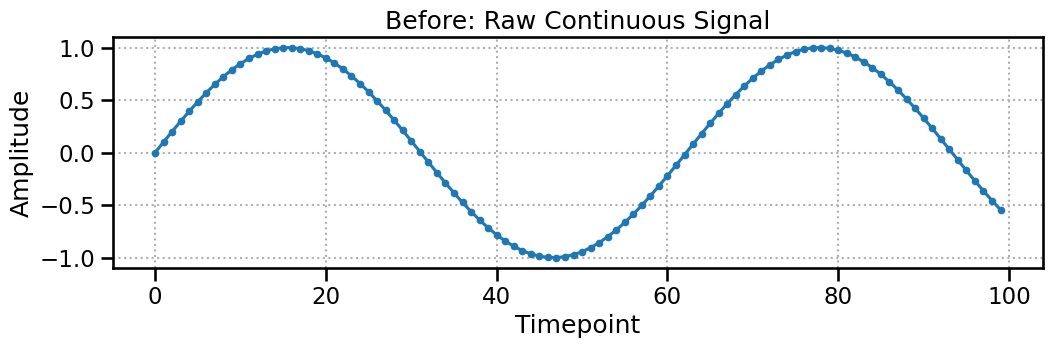

Raw data shape: (1, 100)


In [12]:
raw_continuous_data = np.sin(np.linspace(0, 10, 100)).reshape(1, 100)

plt.figure(figsize=(12, 3))
plt.plot(raw_continuous_data.T, marker='.')
plt.title("Before: Raw Continuous Signal")
plt.xlabel("Timepoint")
plt.ylabel("Amplitude")
plt.grid(True, linestyle=':')
plt.show()

print(f"Raw data shape: {raw_continuous_data.shape}")

### During: The Sliding Window
Now, we apply the `ContinuousProcessor`. We'll use a `window_size` of 10. The processor slides this window along the signal, creating a new, smaller data segment at each step. The plot below shows the exact data (highlighted in red) that is extracted to create the 5th sample.

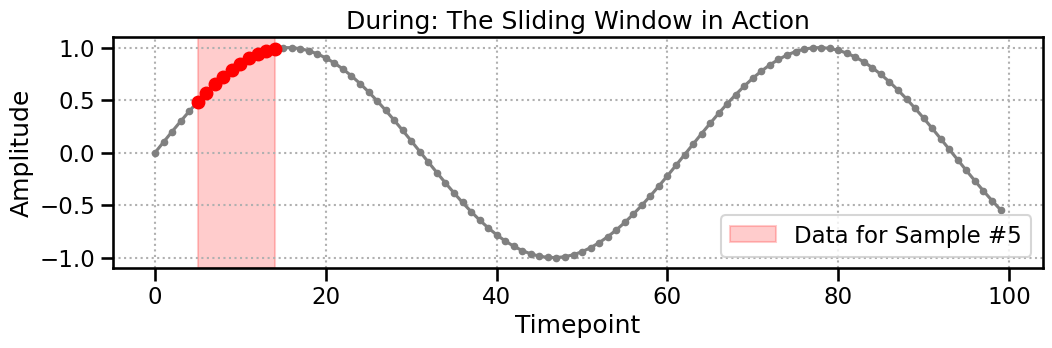

In [13]:
window_size = 10
sample_idx_to_show = 5
start = sample_idx_to_show
end = start + window_size

plt.figure(figsize=(12, 3))
plt.plot(raw_continuous_data.T, color='gray', marker='.')
plt.plot(np.arange(start, end), raw_continuous_data.T[start:end], color='red', marker='o')
plt.axvspan(start, end - 1, color='red', alpha=0.2, label=f'Data for Sample #{sample_idx_to_show}')
plt.title("During: The Sliding Window in Action")
plt.xlabel("Timepoint")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

### After: The Processed Tensor
The final output is a 3D tensor of shape `(n_samples, n_channels, window_size)`. Each of the 91 samples is a snapshot of the signal, 10 timepoints long. The plot below shows the contents of `Sample #5`—it's a perfect match for the highlighted region above!

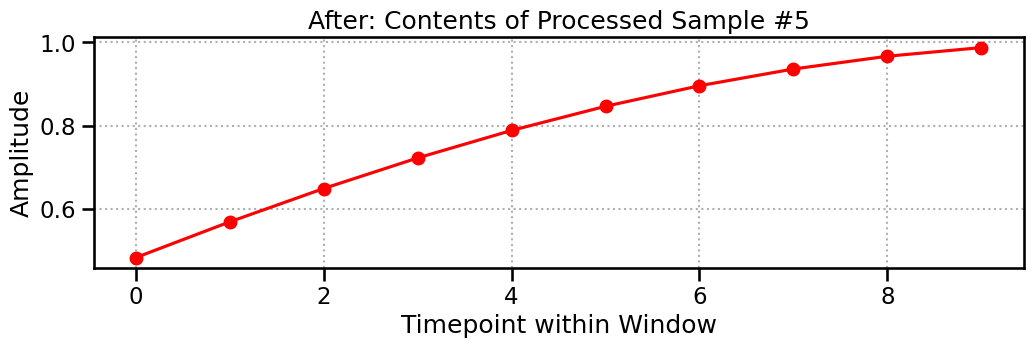

Processed data shape: torch.Size([91, 1, 10])


In [14]:
processor = nmi.data.ContinuousProcessor(window_size=window_size, step_size=1)
processed_data = processor.process(raw_continuous_data)

plt.figure(figsize=(12, 3))
plt.plot(processed_data[sample_idx_to_show, 0, :].numpy(), 'o-', color='red')
plt.title(f"After: Contents of Processed Sample #{sample_idx_to_show}")
plt.xlabel("Timepoint within Window")
plt.ylabel("Amplitude")
plt.grid(True, linestyle=':')
plt.show()

print(f"Processed data shape: {processed_data.shape}")

## 2. Spike Data (Neuronal Firing)

Spike data is fundamentally different. It's a list of discrete event times. The `SpikeProcessor`'s job is to convert this irregular format into a regular 3D tensor our models can use.

### Before: The Raw Spike Raster
We start with a list of arrays, where each array holds the spike times for one neuron. The best way to visualize this is a raster plot.

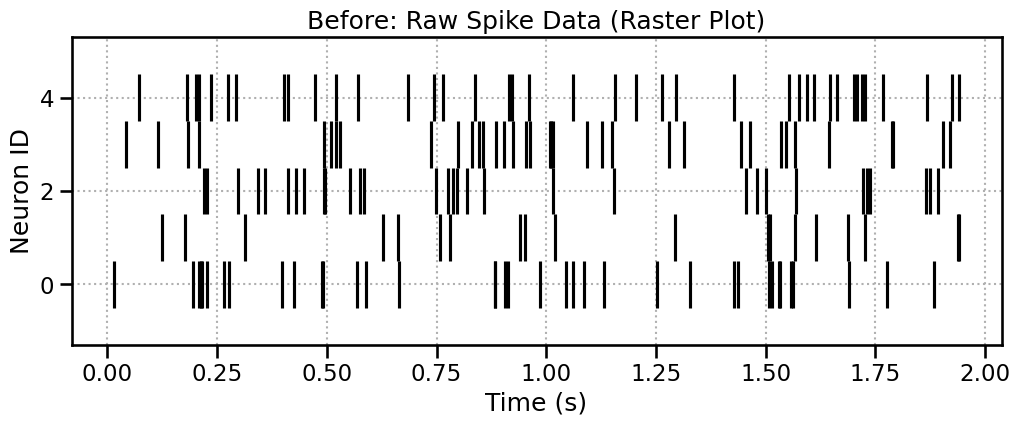

In [15]:
spike_data, _ = nmi.datasets.generate_correlated_spike_trains(
    n_neurons=5, 
    duration=2.0, # Use a shorter duration for visualization
    firing_rate=15
)

plt.figure(figsize=(12, 4))
plt.eventplot(spike_data, color='black')
plt.title("Before: Raw Spike Data (Raster Plot)")
plt.xlabel("Time (s)")
plt.ylabel("Neuron ID")
plt.grid(True, linestyle=':')
plt.show()

### During: Windowing the Spikes
The `SpikeProcessor` also uses a sliding window. It moves across time and collects any spike times that fall within it. Let's highlight the window for `Sample #50`.

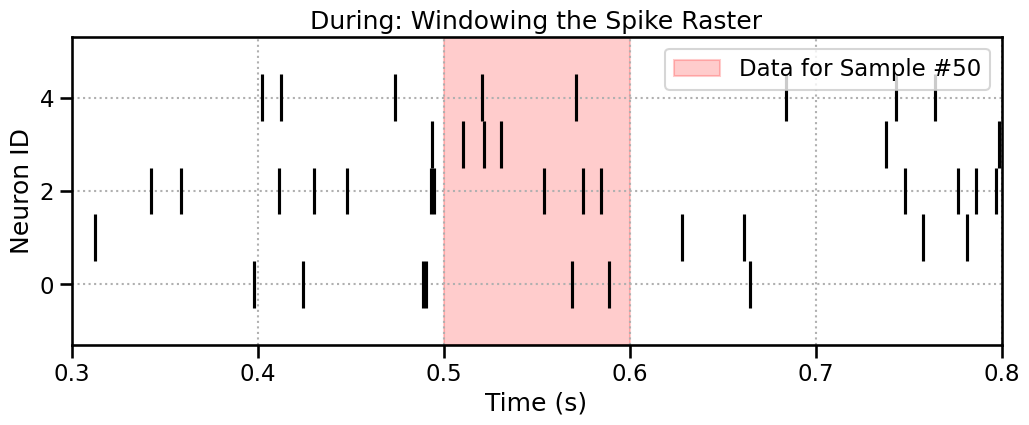

In [16]:
window_size_s = 0.1 # 100 ms
step_size_s = 0.01  # 10 ms
sample_idx_to_show = 50

start_time = sample_idx_to_show * step_size_s
end_time = start_time + window_size_s

plt.figure(figsize=(12, 4))
plt.eventplot(spike_data, color='black')
plt.axvspan(start_time, end_time, color='red', alpha=0.2, label=f'Data for Sample #{sample_idx_to_show}')
plt.title("During: Windowing the Spike Raster")
plt.xlabel("Time (s)")
plt.ylabel("Neuron ID")
plt.xlim(start_time - window_size_s*2, end_time + window_size_s*2)
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

### After: The Padded Tensor of Relative Times
This is the most important step to understand. The final tensor does **not** contain the absolute spike times. It contains:
1.  **Relative Times**: Spike times are measured relative to the start of the window.
2.  **Padding**: Because each window can have a different number of spikes, the results are padded with zeros up to a fixed length (`max_spikes_per_window`).

Let's process the data and visualize the exact contents of `Sample #50`. The text output clearly shows the relative spike times for each neuron and the zero-padding.

In [17]:
max_spikes = nmi.data.processors.find_max_spikes_per_window(spike_data, window_size_s)
spike_processor = nmi.data.SpikeProcessor(
    window_size=window_size_s, step_size=step_size_s, max_spikes_per_window=max_spikes
)
processed_spike_data = spike_processor.process(spike_data)

print(f"After: Contents of Processed Sample #{sample_idx_to_show}")
print("---------------------------------------------------")
print(f"Window Time: [{start_time:.2f}s, {end_time:.2f}s]")
print(f"Processed Tensor Shape: {processed_spike_data.shape}")
print("\nContents (Spike times relative to window start):")
for i in range(len(spike_data)):
    content = processed_spike_data[sample_idx_to_show, i, :].numpy()
    print(f"  Neuron {i}: {np.round(content, 3)}")

After: Contents of Processed Sample #50
---------------------------------------------------
Window Time: [0.50s, 0.60s]
Processed Tensor Shape: torch.Size([184, 5, 7])

Contents (Spike times relative to window start):
  Neuron 0: [0.054 0.074 0.    0.    0.    0.    0.   ]
  Neuron 1: [0. 0. 0. 0. 0. 0. 0.]
  Neuron 2: [0.039 0.06  0.07  0.    0.    0.    0.   ]
  Neuron 3: [0.007 0.016 0.    0.    0.    0.    0.   ]
  Neuron 4: [0.006 0.056 0.    0.    0.    0.    0.   ]


## 3. Categorical Data (Behavioral States, Stimuli)

Categorical data represents discrete states (e.g., resting, running, stimulus on/off). The `CategoricalProcessor` handles this by first **one-hot encoding** the states and then applying a sliding window.

### Before: The Raw State Sequence
Let's generate a sequence of 3 categories (0, 1, 2) for one channel. We can visualize this with `imshow` to see the state transitions over time.

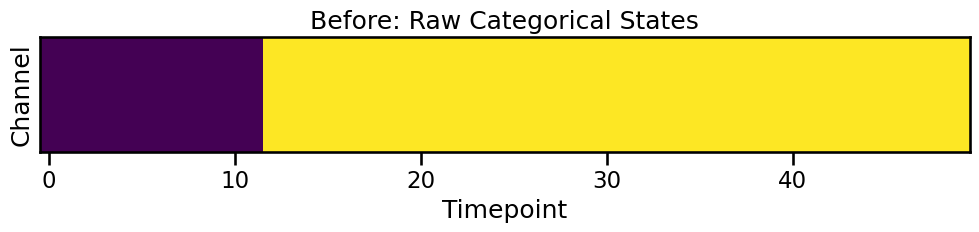

Raw data: [1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]...


In [18]:
raw_cat_data, _ = nmi.datasets.generate_correlated_categorical_series(
    n_samples=50, n_channels=1, n_categories=3, use_torch=False
)

fig, ax = plt.subplots(figsize=(12, 1.5))
ax.imshow(raw_cat_data, aspect='auto', cmap='viridis', interpolation='nearest')
ax.set_title("Before: Raw Categorical States")
ax.set_xlabel("Timepoint")
ax.set_ylabel("Channel")
ax.set_yticks([])
plt.show()
print(f"Raw data: {raw_cat_data[0, :20]}...")

### During & After: One-Hot Encoding and Windowing

The processor takes a window of these integer states, converts each integer to a one-hot vector, and then flattens them into a single feature vector for that sample.

Let's look at the first window. The raw states are `[2, 2, 2]`. Each `2` becomes `[0, 0, 1]`. Concatenated, this becomes `[0, 0, 1, 0, 0, 1, 0, 0, 1]`.

Raw states for first window: [1 1 1]
Processed one-hot vector:    [0. 1. 0. 0. 1. 0. 0. 1. 0.]

Final processed shape: torch.Size([48, 1, 9])


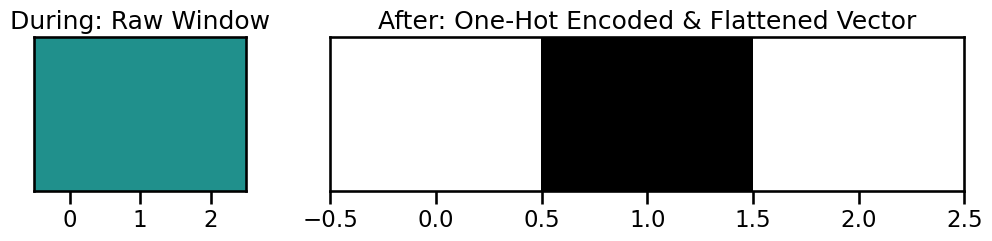

In [19]:
cat_processor = nmi.data.CategoricalProcessor(window_size=3, step_size=1)
processed_cat_data = cat_processor.process(raw_cat_data)

first_window_raw = raw_cat_data[0, :3]
first_window_processed = processed_cat_data[0, 0, :]

print(f"Raw states for first window: {first_window_raw}")
print(f"Processed one-hot vector:    {first_window_processed.numpy()}")
print(f"\nFinal processed shape: {processed_cat_data.shape}")

# Visualize the one-hot encoding
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 2), gridspec_kw={'width_ratios': [1, 3]})
ax1.imshow(first_window_raw.reshape(1, -1), cmap='viridis', aspect='auto', vmin=0, vmax=2)
ax1.set_title("During: Raw Window")
ax1.set_yticks([])

ax2.imshow(first_window_processed.reshape(3, 3), cmap='gray_r', aspect='auto')
ax2.set_title("After: One-Hot Encoded & Flattened Vector")
ax2.set_yticks([])
plt.show()

## 4. Advanced: Aligning Mixed Data Types

What if you want to relate continuous LFP data to spike trains? `NeuralMI` handles this automatically. The internal `DataHandler` processes each data stream and then **aligns them by truncating to the minimum number of samples**. This ensures the final tensors are the same size.

### Before: Unaligned Raw Data
Let's create 10 seconds of LFP data (sampled at 100Hz -> 1000 pts) and 10 seconds of spike data. They cover the same duration but are in different formats.

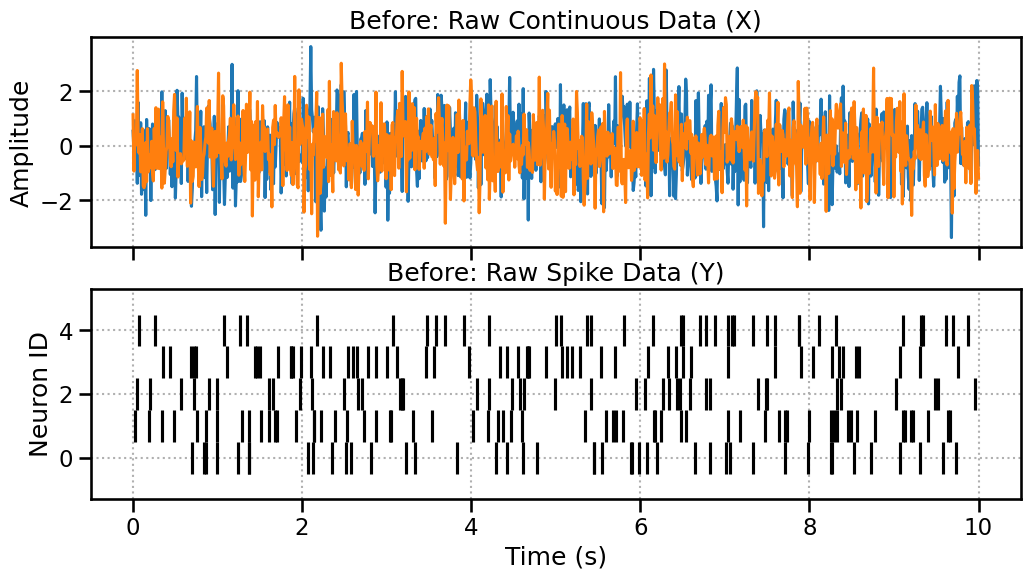

In [20]:
x_cont_raw = np.random.randn(2, 1000)
y_spike_raw, _ = nmi.datasets.generate_correlated_spike_trains(n_neurons=5, duration=10.0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax1.plot(np.linspace(0, 10, 1000), x_cont_raw.T)
ax1.set_title("Before: Raw Continuous Data (X)")
ax1.set_ylabel("Amplitude")
ax1.grid(True, linestyle=':')

ax2.eventplot(y_spike_raw, color='black')
ax2.set_title("Before: Raw Spike Data (Y)")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Neuron ID")
ax2.grid(True, linestyle=':')
plt.show()

### Zoom in a little bit
Here we're just changing the plotting range. However, the number of windows won't be the same.

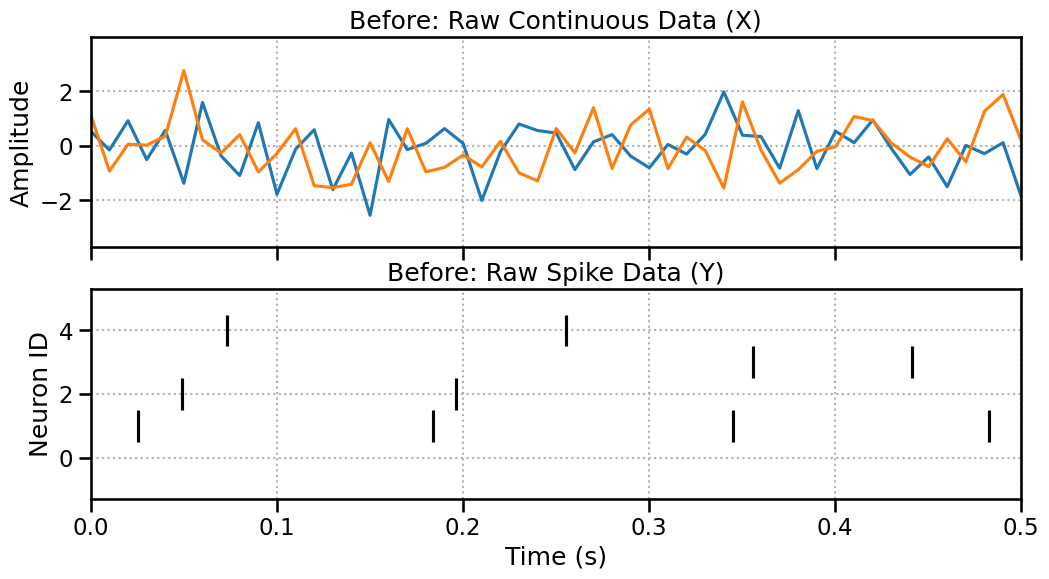

In [55]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax1.plot(np.linspace(0, 10, 1000), x_cont_raw.T)
ax1.set_title("Before: Raw Continuous Data (X)")
ax1.set_ylabel("Amplitude")
ax1.grid(True, linestyle=':')

ax2.eventplot(y_spike_raw, color='black')
ax2.set_title("Before: Raw Spike Data (Y)")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Neuron ID")
ax2.grid(True, linestyle=':')
ax2.set_xlim(0,0.5)
plt.show()

### After: Aligned Processed Tensors

Now we process them. Let's choose parameters that would theoretically produce a different number of samples:
- **Continuous**: `(1000 total pts - 100 win) / 10 step + 1 = 91` samples.
- **Spikes**: `(10s total - 0.5s win) / 0.05s step + 1 = 191` samples.

The library will automatically detect this mismatch and truncate both to the smaller number, **91 samples**.

In [21]:
handler = nmi.data.DataHandler(
    x_data=x_cont_raw, y_data=y_spike_raw,
    processor_type_x='continuous', processor_params_x={'window_size': 100, 'step_size': 10}, # -> 91 samples
    processor_type_y='spike', processor_params_y={'window_size': 0.5, 'step_size': 0.05}     # -> 191 samples
)

x_processed, y_processed = handler.process()

print("--- Theoretical vs. Actual Sample Counts ---")
print("Continuous theoretical samples: 91")
print("Spike theoretical samples: 191")
print("The library will align to the smaller count.\n")
print("--- Final Processed Shapes ---")
print(f"X (Continuous) shape: {x_processed.shape}")
print(f"Y (Spike) shape:      {y_processed.shape}")
print("\nThe number of samples (dim 0) is now identical!")

2025-10-07 17:29:17 - neural_mi - WARNING - Post-trimming mismatch: X has 91, Y has 190. Final truncation.
--- Theoretical vs. Actual Sample Counts ---
Continuous theoretical samples: 91
Spike theoretical samples: 191
The library will align to the smaller count.

--- Final Processed Shapes ---
X (Continuous) shape: torch.Size([91, 2, 100])
Y (Spike) shape:      torch.Size([91, 5, 995])

The number of samples (dim 0) is now identical!


### Plotting the First Window..
Here we can see almost the same plot (maybe we loose a spike at the boundaries) but the number of windows is now the same.

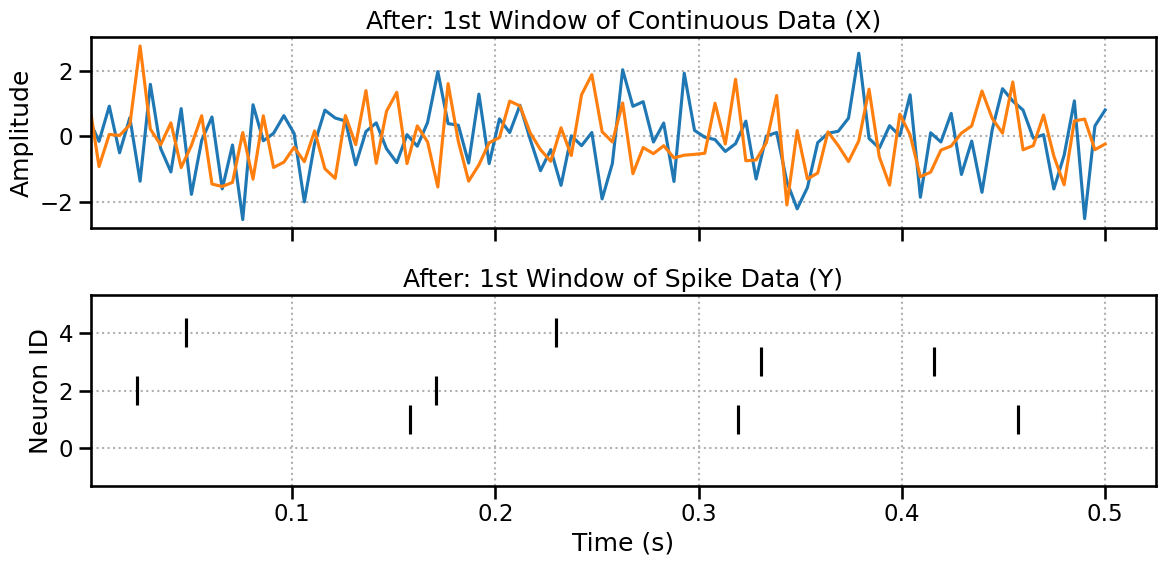

In [54]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax1.plot(np.linspace(0, 0.5, 100), x_processed[0,:,:].T)
ax1.set_title("After: 1st Window of Continuous Data (X)")
ax1.set_ylabel("Amplitude")
ax1.grid(True, linestyle=':')

ax2.eventplot(y_processed[0,:,:], color='black')
ax2.set_title("After: 1st Window of Spike Data (Y)")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Neuron ID")
ax2.grid(True, linestyle=':')
ax2.set_xlim(left=0.001)
plt.tight_layout()
plt.show()

## 5. Conclusion

You now have a strong visual intuition for the crucial role of data processors in `NeuralMI`.

- Data is converted into **3D Tensors** of `(n_samples, n_channels, n_features)`.
- The key operation is the **sliding window**, which captures temporal context.
- Each processor has its own logic: `Continuous` grabs signal values, `Spike` grabs relative times and pads, and `Categorical` one-hot encodes.
- The library automatically **aligns mixed data types** by ensuring they have the same final number of samples.

With this foundation, you are ready for the next tutorial, where we'll learn how to use `mode='sweep'` to find the optimal window size and other key parameters for your analysis.